In [1]:
library(glmnet)
library(leaps)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'leaps' was built under R version 3.6.3"

# Generalized Regulation

In [38]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- na.omit(train)
train.regr <- train[,-3]
train.regr$Intensity <- as.numeric(train.regr$Intensity)

test <- read.csv(file = '../../Data/test_data.csv')
test <- na.omit(test)
test <- test[,-1]
test$Intensity <- as.numeric(test$Intensity)

ZeroVar <- function(data) {
   out <- lapply(data, function(x) length(unique(x)))
   want <- which(!out > 1)
   unlist(want)
}

#Applying the ZeroVar function
train.zeroVar <- train.regr[,-ZeroVar(train.regr)]
x.full.ZV <- as.matrix(train.zeroVar[,-2])
x.test <- test[,-(ZeroVar(train.regr)-1)]
x.test <- as.matrix (x.test)


In [4]:
head(x.test)
head(x.full.ZV)

Intensity,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Depressant.80,Depressant.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
1,31.5,150.34,6.834,12.062,21.338,14.625,24.746,0.548,0.970,...,0,0,0,0,0,0,0,0,0,0
1,196.0,146.15,8.597,12.010,17.305,12.193,18.664,0.706,1.018,...,0,0,0,0,0,0,0,0,0,0
1,79.0,130.21,5.661,12.117,22.840,13.239,26.325,0.527,0.993,...,0,0,0,0,0,0,0,0,0,0
1,95.2,164.27,5.867,15.929,27.396,17.546,31.531,0.569,0.978,...,0,0,0,0,1,0,0,0,1,0
1,48.1,100.18,5.273,9.876,18.629,11.023,21.701,0.520,0.980,...,0,0,0,0,0,0,0,0,0,0
1,137.0,164.22,6.842,14.590,23.956,15.477,26.910,0.608,0.998,...,0,0,0,0,1,0,0,0,1,0


Intensity,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Depressant.80,Depressant.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
2,302.0,208.33,5.952,19.698,34.491,21.523,39.571,0.563,0.985,...,0,0,1,0,1,0,1,0,1,0
1,72.6,122.18,6.431,11.349,18.745,12.261,21.285,0.597,0.987,...,0,0,0,0,0,0,0,0,0,0
1,259.0,242.29,7.572,20.832,32.167,21.693,35.535,0.651,1.005,...,1,0,1,0,1,1,1,0,1,1
1,56.6,88.12,6.294,7.537,14.189,7.955,16.080,0.538,1.014,...,0,0,0,0,0,0,0,0,0,0
2,84.7,136.21,6.191,12.876,21.629,14.023,24.701,0.585,0.983,...,0,0,0,0,0,0,0,0,0,0
1,160.0,192.28,6.409,17.644,29.723,19.000,33.740,0.588,0.991,...,0,0,0,0,1,0,1,0,1,0


### Here we want to CV the alpha parameter

we apply our alternative to proper CV to save time (of course be aware that we loose precision and reroducibility)

In [21]:
A <- seq(0,1,by = 0.1)
CVM <- c()
for (alpha in A){ 
    est <- c()
    for (i in 1:5) {    
        L2.cv <- cv.glmnet(x.full.ZV, train[,2], alpha = alpha, nfolds = 10)
        #plot(L2.cv, main = paste("alpha = ",alpha))
        est <- append(est,min(L2.cv$cvm))
    }
    CVM <- append(CVM,mean(est))
}

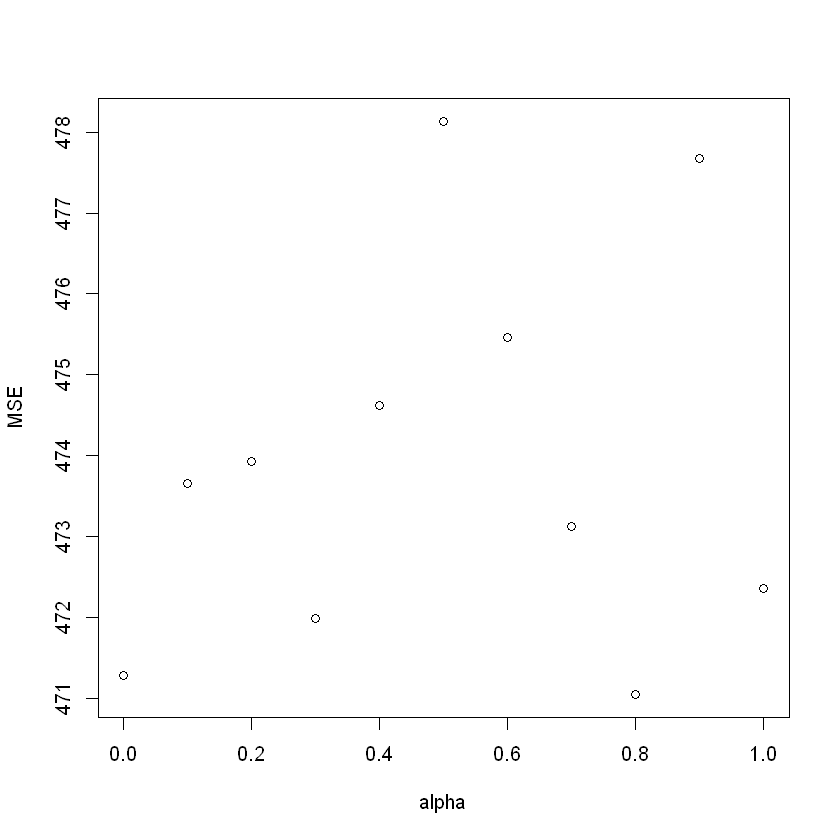

In [22]:
plot(A,CVM,xlab = 'alpha', ylab = 'MSE')

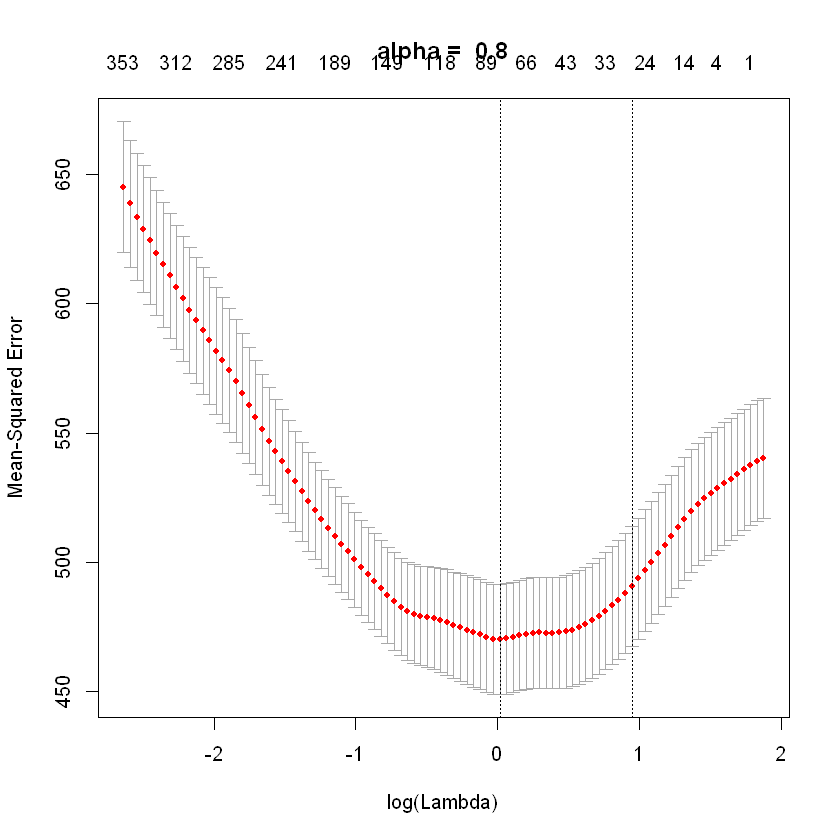

In [6]:
a = A[which.min(CVM)]
cv.best <- cv.glmnet(x.full.ZV, train[,2], alpha = a, nfolds = 10)
plot(cv.best, main = paste("alpha = ",a))

In [8]:
L.best <- glmnet(x.full.ZV,train.zeroVar[,2],alpha = 0.8, lambda = cv.best$lambda.min )
y.pred <- predict (L.best,x.test)

In [10]:
id <- 1:68
temps <- data.frame(y.pred)
final.data <- data.frame(Id = id,VALENCE.PLEASANTNESS = temps$s0)
write.csv(final.data,"../../Submission/GenR.csv",row.names = FALSE)

### Let s try something: first regsubset and a lambda reg

In [41]:
forward <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.zeroVar,nvmax = 300,really.big=T,method="forward")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2696  linear dependencies found"

Reordering variables and trying again:


In [42]:
name <- names(coef(forward,id = 300)[-1])
data.clean <- train.zeroVar[name]
dim(data.clean)


[1] 708 300

let's try again to cv alpha with the subset selection of features

In [23]:
A <- seq(0,1,by = 0.05)
CVM <- c()
for (alpha in A){ 
    est <- c()
    for (i in 1:5) {    
        L <- cv.glmnet(as.matrix(data.clean), train[,2], alpha = alpha, nfolds = 10)
        est <- append(est,min(L$cvm))
    }
    CVM <- append(CVM,mean(est))
}


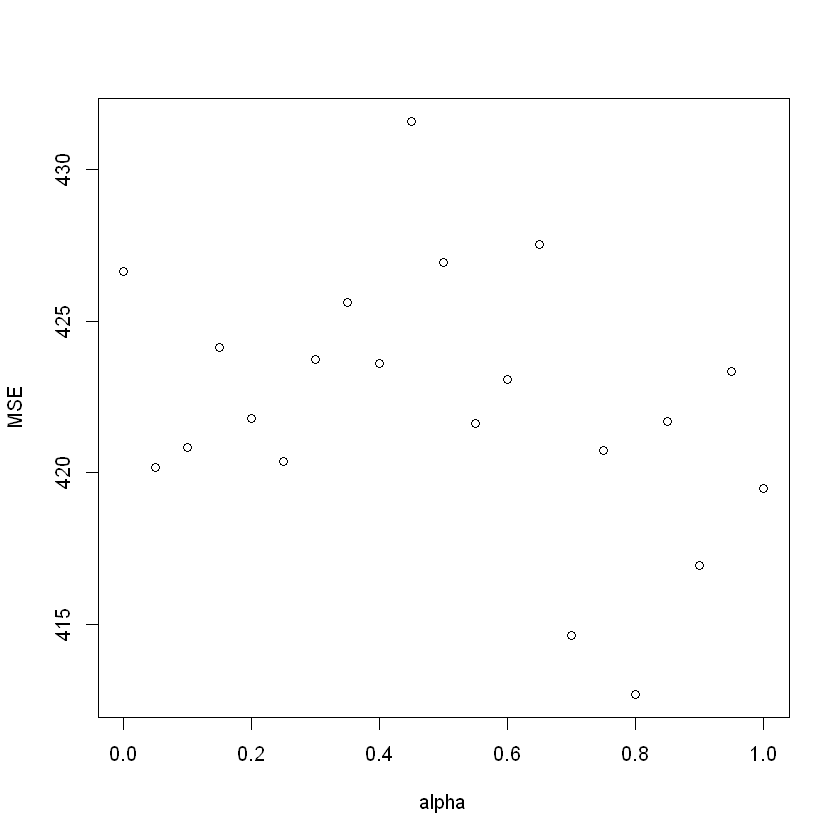

In [24]:
plot(A,CVM,xlab = 'alpha', ylab = 'MSE')

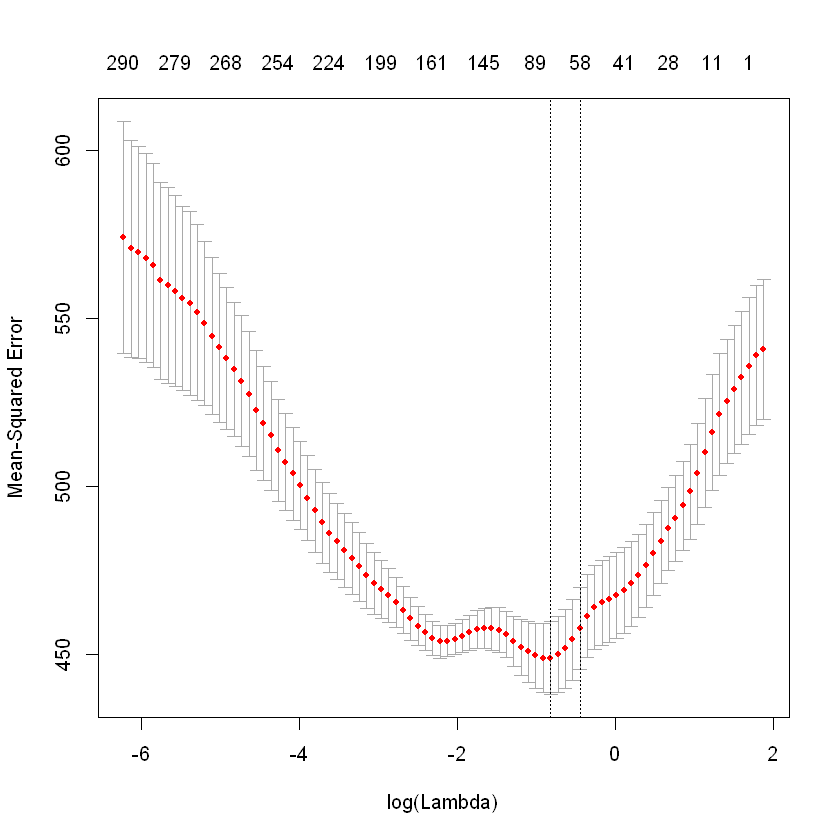

In [40]:
cv.L <- cv.glmnet(as.matrix(data.clean), train[,2], alpha = 0.8, nfolds = 10)
plot(cv.L)

In [7]:
test <- x.test[,name]
head(test)
head(as.matrix(data.clean))

Intensity,RBF,ZM1Kup,PW3,X1v,X3sol,X1Per,SpPos_L,VE2_Dt,VE2_Dz.v.,...,F02.O.S.,F03.C.O.,F04.O.O.,F04.O.S.,F05.C.N.,DLS_01,DLS_02,DLS_cons,CMC.80,Depressant.50
1,0.238,55.721,0.223,5.646,2.748,2.597,14,0.320,0.313,...,0,0,0,0,0,1,0.67,0.79,0,0
1,0.000,197.471,0.325,3.350,3.802,2.701,24,0.236,0.274,...,0,5,0,0,0,1,0.67,0.70,0,0
1,0.227,117.885,0.216,3.488,1.635,2.889,16,0.303,0.302,...,0,2,0,0,0,1,0.83,0.95,0,0
1,0.179,114.150,0.270,4.580,3.191,3.755,24,0.265,0.265,...,0,1,0,0,0,1,0.83,0.94,1,0
1,0.167,64.150,0.219,2.673,1.207,2.210,12,0.335,0.337,...,0,1,0,0,0,1,0.83,0.91,0,0
1,0.167,181.471,0.292,4.022,3.489,3.254,24,0.268,0.273,...,0,5,0,0,0,1,0.83,0.85,1,0


Intensity,RBF,ZM1Kup,PW3,X1v,X3sol,X1Per,SpPos_L,VE2_Dt,VE2_Dz.v.,...,F02.O.S.,F03.C.O.,F04.O.O.,F04.O.S.,F05.C.N.,DLS_01,DLS_02,DLS_cons,CMC.80,Depressant.50
2,0.111,189.471,0.330,5.838,5.358,4.570,32,0.239,0.233,...,0,2,0,0,0,1,1.00,1.00,1,0
1,0.053,117.736,0.308,2.934,2.713,2.348,18,0.290,0.279,...,0,2,0,0,0,1,0.83,0.84,0,0
1,0.152,293.207,0.318,5.670,5.756,4.556,38,0.211,0.222,...,0,7,0,0,0,1,1.00,0.87,1,0
1,0.077,107.885,0.267,1.871,1.333,1.507,10,0.397,0.385,...,0,4,0,0,0,1,0.83,0.95,0,0
2,0.091,108.150,0.322,3.573,3.099,2.919,20,0.302,0.295,...,0,3,0,0,0,1,0.83,0.84,0,0
1,0.200,189.471,0.288,5.022,3.981,4.067,28,0.244,0.248,...,0,4,0,0,0,1,0.83,0.95,1,0


In [11]:
L.reg <- glmnet(as.matrix(data.clean),train.zeroVar[,2],alpha = 0.8, lambda = cv.L$lambda.min )
y.pred <- predict (L.reg,test)

In [12]:
id <- 1:68
temps <- data.frame(y.pred)
final.data <- data.frame(Id = id,VALENCE.PLEASANTNESS = temps$s0)
write.csv(final.data,"../../Submission/FullReg.csv",row.names = FALSE)

It gave nothing on the test set, it is quite weird as it is one of the best validation error we got. It turned out it was not so reproducible (if we run several times the cell). I am wondering why the CV cell had so low validation error... Let's try to re run it below (to keep track of the first one)

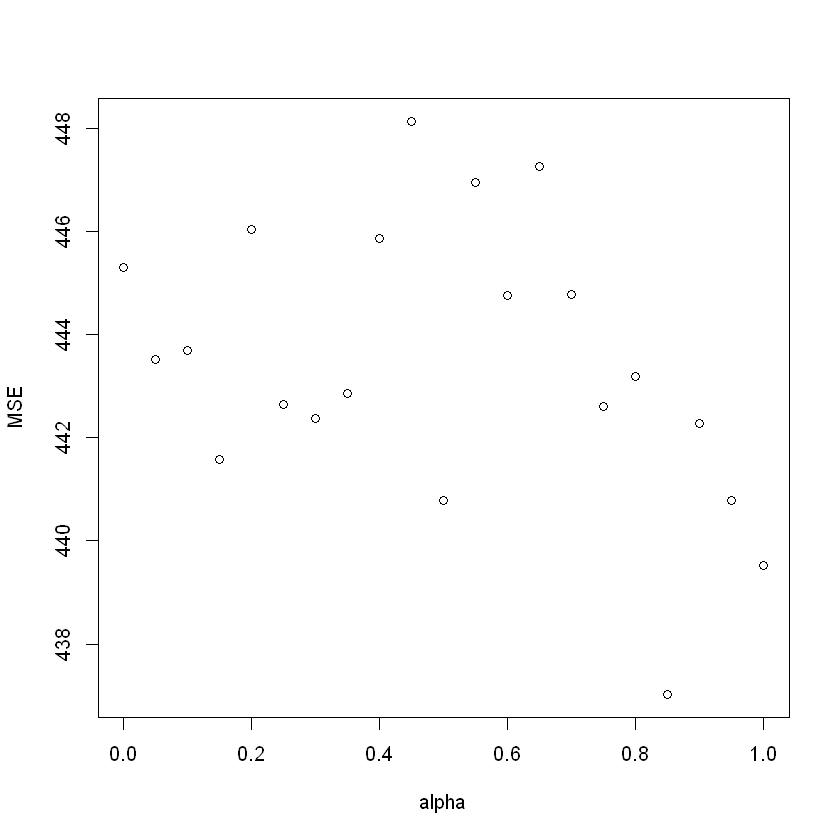

In [43]:
A <- seq(0,1,by = 0.05)
CVM <- c()
for (alpha in A){ 
    est <- c()
    for (i in 1:5) {    
        L <- cv.glmnet(as.matrix(data.clean), train[,2], alpha = alpha, nfolds = 10)
        est <- append(est,min(L$cvm))
    }
    CVM <- append(CVM,mean(est))
}
plot(A,CVM,xlab = 'alpha', ylab = 'MSE')

To end this section, I feel a little bit confused. The CV gave sigificant different result (with the same hyperparamter). 
This implies that the CV function provided by glmnet is not very robust (it in on an other hand rather fast !). Actually, it is also coming from the fact that our alternative CV is only run 5 times (5 different splits).
So we cannot really base our results/submissions on this. You can also see above that a good cv given by cv.glmnet was found; but when applied to the tes test it just totally failed.

### A last approach would be to remove manually features (manual feature selection) that are not very correlated with the response and eachother:

Here is a mix of removing correlation between features and keeping only feature which have significant correlation with the response

In [ ]:
library(caret)

In [23]:
train.Z <- subset(train.regr,select = -nearZeroVar(train))
corY <- cor(train.Z)[,2]
cut <- sort(which(abs(corY)>0.05, arr.ind=TRUE))

Warning message in cor(train.Z):
"l'écart type est nulle"

We see that the highest correlation with the response is about 0.2; so low ->very bad ! 

In [24]:
T <- train.Z[,cut]
head(T)
dim(T)

VALENCE.PLEASANTNESS,complexity.from.pubmed,MW,Sv,Se,Sp,Si,nAT,nSK,nBT,...,Vx,VvdwMG,VvdwZAZ,BLTF96,BLTD48,BLTA96,LLS_01,LLS_02,CMC.80,CMC.50
45,302.0,208.33,19.698,34.491,21.523,39.571,35,15,36,...,291.445,122.822,221.04,-3.96,-4.19,-4.26,0.67,1,1,0
49,72.6,122.18,11.349,18.745,12.261,21.285,19,9,19,...,175.565,75.330,124.57,-3.25,-3.40,-3.42,1.00,1,0,0
56,259.0,242.29,20.832,32.167,21.693,35.535,32,18,33,...,312.292,131.366,229.43,-4.11,-4.36,-4.43,0.67,1,1,0
7,56.6,88.12,7.537,14.189,7.955,16.080,14,6,13,...,124.020,54.205,92.70,-1.89,-1.88,-1.82,1.00,1,0,0
51,84.7,136.21,12.876,21.629,14.023,24.701,22,10,22,...,198.970,84.922,141.87,-3.30,-3.45,-3.47,1.00,1,0,0
21,160.0,192.28,17.644,29.723,19.000,33.740,30,14,30,...,271.794,114.768,199.92,-3.90,-4.13,-4.19,0.83,1,1,0


[1]  708 1723

In [33]:
X <- subset(T,select = -VALENCE.PLEASANTNESS)
correlation <- cor(X)
id <- sort(findCorrelation(correlation, cutoff=0.9))
X <- X[,-id]

In [34]:
dim(X)
head(X)

[1] 708 373

nDB,C.,NNRS,nR06,ZM1Mad,ZM1MulPer,Qindex,BLI,SPI,PJI2,...,F04.C.S.,F05.C.S.,Hy,TPSA.Tot.,MLOGP2,BLTF96,LLS_01,LLS_02,CMC.80,CMC.50
2,37.1,0.5,2,85.867,177.580,13,1.095,8.808,1.0,...,0,0,-0.846,26.30,9.154,-3.96,0.67,1,1,0
0,42.1,1.0,1,42.879,112.446,5,0.978,4.176,1.0,...,0,0,-0.848,9.23,4.808,-3.25,1.00,1,0,0
1,46.9,1.0,2,95.410,275.179,10,0.895,7.015,1.0,...,0,0,-0.818,35.53,10.254,-4.11,0.67,1,1,0
1,28.6,0.0,0,26.428,99.252,2,1.123,3.786,0.5,...,0,0,0.158,37.30,0.344,-1.89,1.00,1,0,0
0,40.9,1.0,1,46.104,107.222,5,1.072,4.443,1.0,...,0,0,-0.257,20.23,5.026,-3.30,1.00,1,0,0
1,40.0,1.0,1,65.867,177.349,5,1.076,6.253,1.0,...,0,0,-0.835,26.30,8.753,-3.90,0.83,1,1,0


lets run CV on this feature selection:

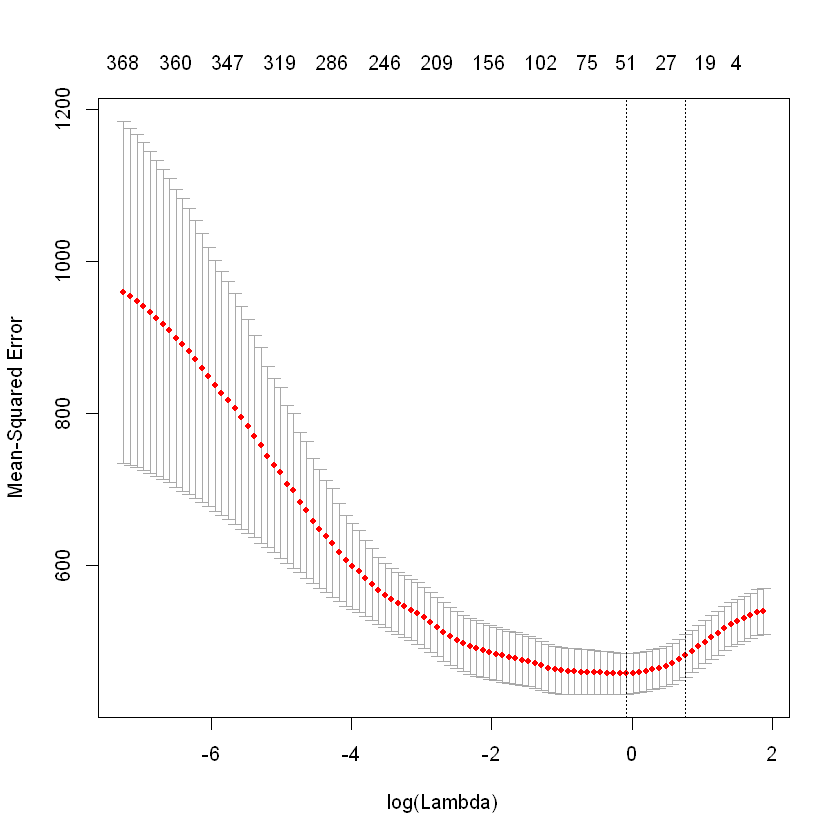

In [46]:
cv <- cv.glmnet(as.matrix(X),train[,'VALENCE.PLEASANTNESS'],alpha = 0.8,nfolds = 12)
plot(cv)

The results are not really better ... We won't try a submission